# Bibliotécas

In [73]:
# Manipulação de dados
import pandas as pd
import numpy as np
import inflection

# Visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib as mpl

# Modelagem estatística
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

# Machine Learning: Modelos e Avaliação
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import model_selection as ms
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from skopt import BayesSearchCV

# Pipelines para tratar dados futuros
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Utilitários
import warnings
import pickle
from IPython.display import HTML

%matplotlib inline

warnings.filterwarnings('ignore')

mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['grid.color'] = 'lightgray'
mpl.rcParams['axes.grid'] = True
mpl.rcParams['font.size'] = 12

#Configurando as paleta de cores
color_palette = ['#023047', '#e85d04', '#0077b6', '#ff8200', '#0096c7', '#ff9c33']
sns.set_palette(sns.color_palette(color_palette))

#Cores utilizadas
#sns.color_palette(color_palette)

# Funções

In [74]:
#from IPython.display import HTML
def jupyter_settings():
    %matplotlib inline

    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [20, 9]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.container{width: 100% !important;}</style>'))
    
    pd.options.display.max_rows = None
    pd.options.display.max_columns = None
    pd.set_option('display.expand_frame_repr', False)

    sns.set()

    # Aumenta a quantidade de texto mostrado nas células de saída
    from IPython.core.interactiveshell import InteractiveShell
    InteractiveShell.ast_node_interactivity = 'all'
jupyter_settings()

#import inflection
def renomear_colunas(df):
    title = lambda x: inflection.titleize(x)
    snakecase = lambda x: inflection.underscore(x)
    spaces = lambda x: x.replace(" ", "")
    cols_old = list(df.columns)
    cols_old = list(map(title, cols_old))
    cols_old = list(map(spaces, cols_old))
    cols_new = list(map(snakecase, cols_old))
    df.columns = cols_new
    return df

def descricao_estatistica_variaveis_numericas(df):
    #Métricas de tendência central: média e mediana
    central_1 = pd.DataFrame(df.apply(np.mean)).T
    central_2 = pd.DataFrame(df.apply(np.median)).T
    
    #Métricas de dispersão: desvio padrão, mínimo, máximo, aplitude, assimetrica e curtose
    dispersao_1 = pd.DataFrame(df.apply(np.std)).T
    dispersao_2 = pd.DataFrame(df.apply(np.min)).T
    dispersao_3 = pd.DataFrame(df.apply(np.max)).T
    dispersao_4 = pd.DataFrame(df.apply(lambda x: x.max() - x.min())).T
    dispersao_5 = pd.DataFrame(df.apply(lambda x: x.skew())).T
    dispersao_6 = pd.DataFrame(df.apply(lambda x: x.kurtosis())).T
    
    metricas = pd.concat([dispersao_2, dispersao_3, dispersao_4, central_1, central_2, dispersao_1, dispersao_5, dispersao_6]).T
    metricas.columns = ['min', 'max', 'amplitude', 'mean', 'median', 'std', 'assimetria', 'kurtosis']
    return metricas

def descricao_estatistica_variaveis_categoricas(df):
    return df.apply(lambda x: x.unique().shape[0])

def converter_para_int(dataframe: pd.DataFrame, nome_coluna: str) -> bool:
    try:
        dataframe[nome_coluna] = dataframe[nome_coluna].astype(int)
        return True
    except ValueError:
        print(f"Erro: Não foi possível converter a coluna '{nome_coluna}' para tipo inteiro.")
        return False

def converter_para_data(dataframe: pd.DataFrame, nome_coluna: str, formato_data: str = None) -> bool:
    try:
        dataframe[nome_coluna] = pd.to_datetime(dataframe[nome_coluna])
        return True
    except ValueError:
        print(f"Erro: Não foi possível converter a coluna '{nome_coluna}' para tipo de data.")
        return False

#import numpy as np
#import pandas as pd
#from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
#from sklearn.model_selection import KFold

def ml_error(y, y_pred, desvpad = True):
    mae = mean_absolute_error(y, y_pred)
    mape = np.mean(np.abs((y - y_pred) / y)) * 100
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    std_mae = np.std(np.abs(y - y_pred))
    std_mape = np.std(np.abs((y - y_pred) / y))
    std_rmse = np.std(np.sqrt(y - y_pred))
    
    # Substituir NaN por 0
    std_mae = 0 if np.isnan(std_mae) else std_mae
    std_mape = 0 if np.isnan(std_mape) else std_mape
    std_rmse = 0 if np.isnan(std_rmse) else std_rmse
    
    if desvpad:
        return pd.DataFrame({'mae': f"{mae:.2f} +/- {std_mae:.2f}",
                             'mape': f"{mape:.2f}% +/- {std_mape:.2f}%",
                             'rmse': f"{rmse:.2f} +/- {std_rmse:.2f}",
                             'r2': f"{r2:.2f}"}, index = [0])
    else:
        return pd.DataFrame({'mae': f"{mae:.2f}",
                             'mape': f"{mape:.2f}%",
                             'rmse': f"{rmse:.2f}",
                             'r2': f"{r2:.2f}"}, index = [0])
        
def dados_faltantes(df):
    faltantes_qtde = df.isna().sum()
    faltantes_perc = df.isna().mean() * 100
    return pd.DataFrame({'Qtde Faltantes': faltantes_qtde,
                         'Perc Faltantes (%)': faltantes_perc}).round(2)
    
def linhas_duplicadas(df):
    return (df.groupby(df.columns.tolist(), dropna = False)
              .size()
              .to_frame('qtde_linhas_duplicadas')
              .query('qtde_linhas_duplicadas > 1')
              .sort_values('qtde_linhas_duplicadas', ascending = False))

def curva_gaussiana(df):
    # Verificar se as distribuições são normais
    columns = df.select_dtypes(include = 'number').columns

    # Nível de significância para o teste (por exemplo, 0.05)
    alpha = 0.05

    # Lista para armazenar os resultados
    results = []

    # Aplicar o teste de Shapiro-Wilk para cada coluna e armazenar os resultados
    for col in columns:
        # Remove valores NaN antes de aplicar o teste
        stat, p_value = stats.shapiro(df[col].dropna())

        # Determina se a variável segue uma distribuição normal com base no p-valor
        if p_value > alpha:
            normality = "Distribuição normal"
        else:
            normality = "Não segue distribuição normal"

        results.append({'Variável': col.capitalize(),
                        'Estatística': f"{stat:.4f}",
                        'p-valor': f"{p_value:.8f}",
                        'Normalidade': normality})
    return pd.DataFrame(results)

# 1. (Limpeza dos dados) Passo 1: Descrição dos dados

### 1.1 Descrição do desafio

#### Você recebeu uma tarefa de criar um modelo de machine learning para auxiliar uma construtora a medir a resistência do concreto,
#### pois eles dependem dessa questão para construir os seus projetos, e a equipe de engenheiros está interessada em prever a
#### resistência do concreto, que é a parte mais importante da constução civil, dado algumas características que eles têm disponíveis. 

#### 1.7.1 Descrição das colunas

**Cement (Cimento):** O cimento é um dos principais componentes do concreto. Ele é responsável por ligar os outros materiais, como agregados, e formar uma massa coesa. O tipo e a quantidade de cimento utilizados podem influenciar significativamente a resistência do concreto.

**Slag (Escarpa):** Slag, ou escarpa, é um subproduto da produção de aço, frequentemente usado como componente do cimento ou como adição ao concreto. Sua presença pode afetar propriedades como resistência e durabilidade.

**Flyash (Cinzas volantes):** Cinzas volantes são subprodutos resultantes da queima de carvão em usinas termoelétricas. Elas podem ser usadas como adição ao cimento ou ao concreto, proporcionando benefícios como melhoria da trabalhabilidade, redução do calor de hidratação e aumento da durabilidade.

**Water (Água):** A água é um componente essencial do concreto, pois é necessária para a hidratação do cimento, que é o processo pelo qual o cimento reage quimicamente e endurece. A quantidade de água utilizada afeta a trabalhabilidade e a resistência do concreto.

**Superplasticizer (Superplastificante):** Superplastificantes são aditivos químicos adicionados ao concreto para melhorar sua trabalhabilidade sem aumentar significativamente a quantidade de água. Eles permitem a redução da relação água/cimento, o que pode resultar em concretos mais resistentes e duráveis.

**Coarse Aggregate (Agregado graúdo):** Os agregados graúdos são partículas de materiais como pedra britada, cascalho ou pedregulho, que são adicionados ao concreto para aumentar sua resistência. Eles fornecem suporte estrutural e ajudam a reduzir a quantidade de pasta de cimento necessária.

**Fine Aggregate (Agregado fino):** Os agregados finos são partículas de materiais como areia ou pó de pedra, que são adicionados ao concreto para preencher os espaços entre os agregados graúdos e melhorar a trabalhabilidade.

**Age (Idade em dias):** A idade do concreto se refere ao tempo decorrido desde sua mistura inicial até o momento da avaliação. A idade do concreto pode afetar sua resistência e outras propriedades, uma vez que o processo de cura e endurecimento continua ao longo do tempo.

<span style = "color:yellow">**cs_m_pa</span> (Resistência Compressiva em Megapascal):** Este é o atributo alvo que o modelo de previsão deve estimar. Representa a resistência do concreto à compressão, medida em megapascal (MPa). É uma medida crítica da qualidade e da adequação do concreto para determinadas aplicações na construção civil.

### 1.2 Carregar os dados

In [75]:
df_raw = pd.read_csv('../dataset/dados.csv')

In [76]:
df1 = df_raw.copy()

In [77]:
df1.head(3)

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.00,0.00,0.00,162.00,2.50,1040.00,676.00,28,79.99
1,540.00,0.00,0.00,162.00,2.50,1055.00,676.00,28,61.89
2,332.50,142.50,0.00,228.00,0.00,932.00,594.00,270,40.27


### 1.3 Dimensão dos dados

In [78]:
df1.shape

(1030, 9)

### 1.4 Editar as colunas

In [79]:
renomear_colunas(df1).head(3)

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,cs_m_pa
0,540.00,0.00,0.00,162.00,2.50,1040.00,676.00,28,79.99
1,540.00,0.00,0.00,162.00,2.50,1055.00,676.00,28,61.89
2,332.50,142.50,0.00,228.00,0.00,932.00,594.00,270,40.27


### 1.5 Tipo de dados

In [80]:
df1.dtypes

cement              float64
slag                float64
flyash              float64
water               float64
superplasticizer    float64
coarseaggregate     float64
fineaggregate       float64
age                   int64
cs_m_pa             float64
dtype: object

#### <s>1.5.1 Editar os tipos de dados</s>

### 1.6 Verificar NA's

In [81]:
dados_faltantes(df1)

,Qtde Faltantes,Perc Faltantes (%)
cement,0,0.00
slag,0,0.00
flyash,0,0.00
water,0,0.00
superplasticizer,0,0.00
coarseaggregate,0,0.00
fineaggregate,0,0.00
age,0,0.00
cs_m_pa,0,0.00


#### <s>1.6.1 Tratar NA's</s>

#### <s>1.6.2 Verificar NA's novamente</s>

### 1.7 Verificar valores duplicados

In [82]:
linhas_duplicadas(df1)

qtde_linhas_duplicadas
cement slag   flyash water  superplasticizer coarseaggregate fineaggregate age cs_m_pa                        
362.60 189.00 0.00   164.90 11.60            944.70          755.80        3   35.30                         4
                                                                           28  71.30                         4
                                                                           56  77.30                         4
                                                                           91  79.30                         4
                                                                           7   55.90                         3
425.00 106.30 0.00   153.50 16.50            852.10          887.10        3   33.40                         3
                                                                           7   49.20                         3
                                                                           28  60.29                         3
                                                                           56  64.30                         3
                                                                           91  65.20                         3
252.00 0.00   0.00   185.00 0.00             1111.00         784.00        28  19.69                         2

In [83]:
# Removendo os valores duplicados
df1.drop_duplicates(inplace = True)

### 1.8 Descrição estatística do negócio

In [84]:
descricao_estatistica_variaveis_numericas(df1)

,min,max,amplitude,mean,median,std,assimetria,kurtosis
cement,102.00,540.00,438.00,278.63,265.00,104.29,0.56,-0.43
slag,0.00,359.40,359.40,72.04,20.00,86.13,0.86,-0.41
flyash,0.00,200.10,200.10,55.54,0.00,64.18,0.50,-1.37
water,121.80,247.00,125.20,182.08,185.70,21.33,0.03,0.17
superplasticizer,0.00,32.20,32.20,6.03,6.10,5.92,0.98,1.70
coarseaggregate,801.00,1145.00,344.00,974.38,968.00,77.54,-0.07,-0.58
fineaggregate,594.00,992.60,398.60,772.69,780.00,80.30,-0.25,-0.11
age,1.00,365.00,364.00,45.86,28.00,63.70,3.25,11.96
cs_m_pa,2.33,82.60,80.27,35.25,33.80,16.28,0.40,-0.31


* As medidas estatísticas ajudam a entender a distribuição, a tendência central e a dispersão dos dados, fornecendo uma informação inicial a cerca dos dados estudados, as principais são:

**Mínimo (Min):** Ajuda a entender o limite inferior dos dados;

**Máximo (Máx):** Indica o limite superior dos dados;

**Amplitude:** Diferença entre o valor máximo e mínimo. Fornece uma ideia da dispersão total dos dados;

**Média:** Oferece uma medida do valor central dos dados;

<span style = "color:yellow">**Mediana:</span>** É uma medida de posição que não é influenciada por valores extremos e fornece uma visão robusta da tendência central dos dados;

<span style = "color:yellow">**Desvio Padrão:</span>** Um desvio padrão maior indica uma maior dispersão dos dados em relação à média;

 * Obs.: <span style = "color:yellow">Avaliar se estas medidas estão próximas, o que indica uma distribuição normal dos dados</span>

**Assimetria:** Uma distribuição simétrica terá uma assimetria próxima de zero. Uma assimetria positiva indica uma cauda mais longa à direita da distribuição, enquanto uma assimetria negativa indica uma cauda mais longa à esquerda;

**Curtose:** Refere-se à forma da distribuição dos dados em relação a seu pico. Uma curtose alta indica uma distribuição mais concentrada ao redor da média, com caudas mais pesadas, enquanto uma curtose baixa indica uma distribuição mais plana e com caudas mais leves.

# 2. (Limpeza dos dados) Passo 2: Engenharia de variáveis

In [85]:
df2 = df1.copy()

# 3. (Limpeza dos dados) Passo 3: Filtragem de variáveis (restrição do negócio)

In [86]:
df3 = df2.copy()

# 4. (Exploração dos dados) Passo 4: Análise exploratória dos dados

In [87]:
df4 = df3.copy()

### 4.1 Análise univariada

#### 4.1.1 Variável resposta

In [88]:
df1.columns

Index(['cement', 'slag', 'flyash', 'water', 'superplasticizer',
       'coarseaggregate', 'fineaggregate', 'age', 'cs_m_pa'],
      dtype='object')

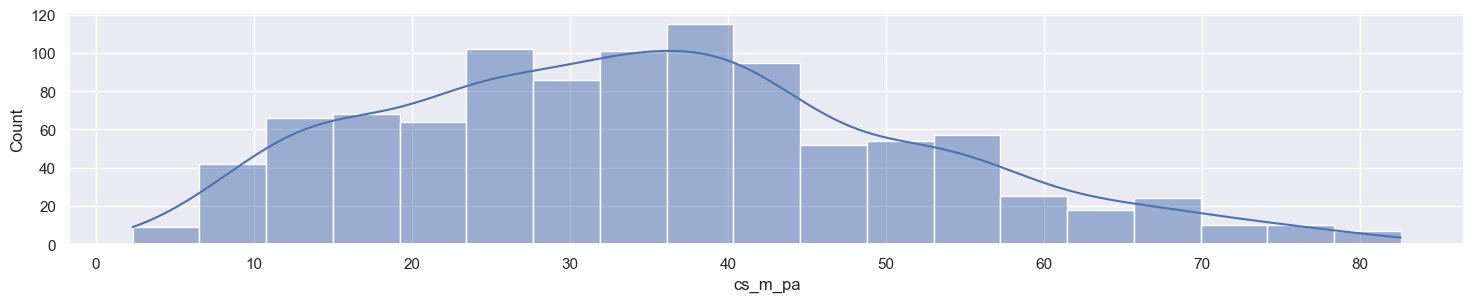

In [89]:
plt.figure(figsize = (18, 3)) #Ajuste o tamanho conforme necessário

#cs_m_pa
sns.histplot(x = 'cs_m_pa', data = df4, kde = True);

* Na análise univariada, busca-se avaliar o comportamento da variável resposta. Neste caso, a variável resposta exibe uma distribuição 'quase' normal, o que significa que os dados estão principalmente concentrados na porção inferior a 40 no histograma. Isso sugere que a maioria dos dados está agrupada antes desta faixa específica, indicando uma tendência central na distribuição dos dados.

#### 4.1.2 Variáveis preditoras

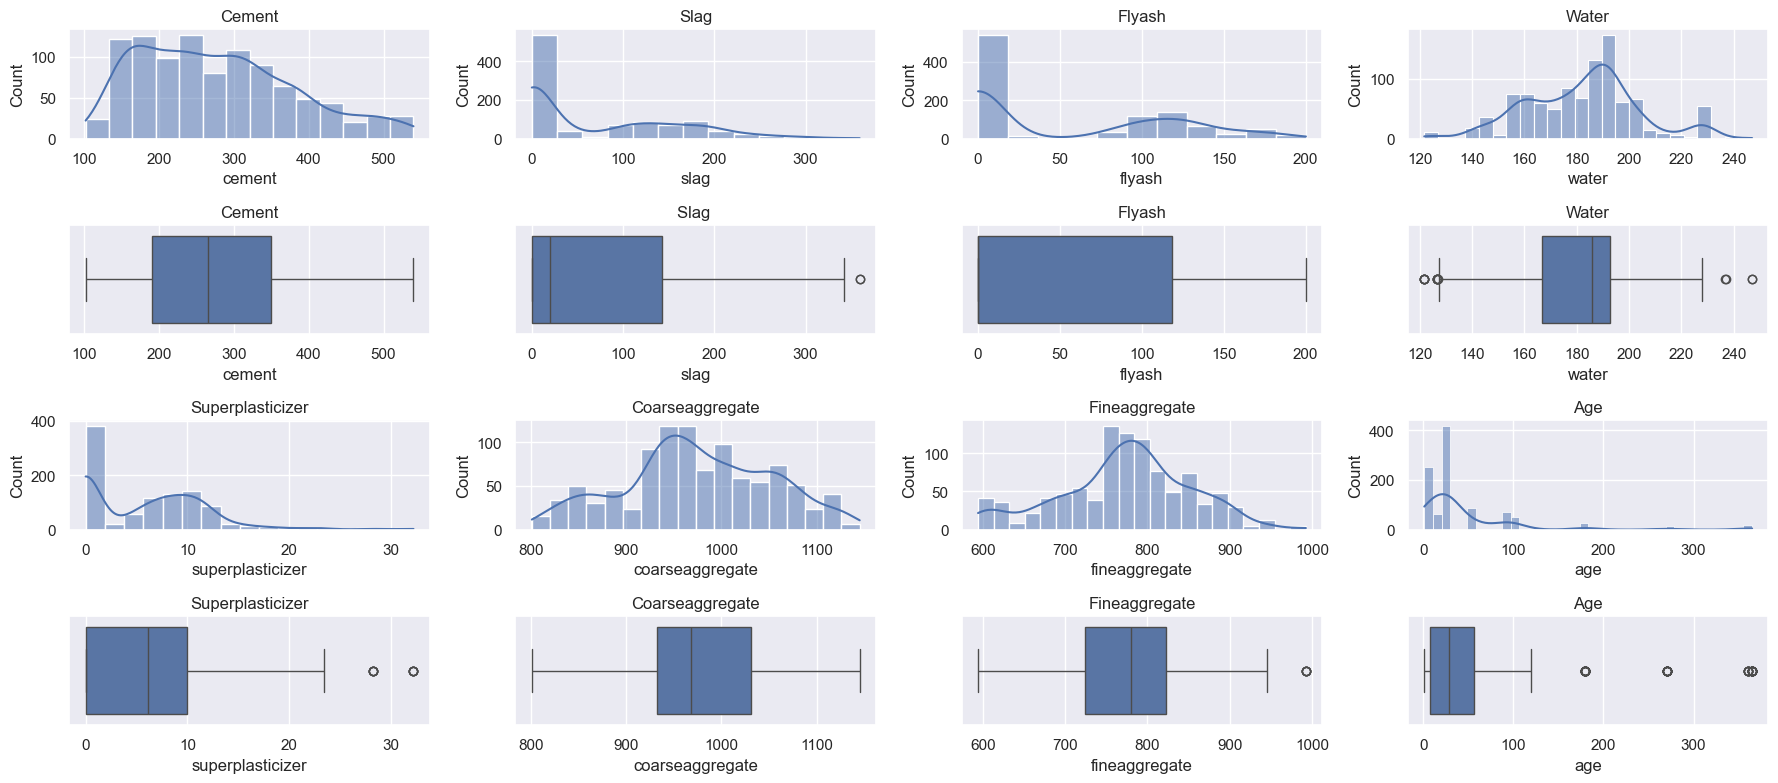

In [90]:
fig = plt.figure(figsize = (18, 8))
grid = GridSpec(4, 4, figure = fig)

# Gráficos de barras à esquerda
# cement
plt.subplot(grid[0, 0])
sns.histplot(x = 'cement', data = df4, kde = True)
plt.title('Cement')

# slag
plt.subplot(grid[0, 1])
sns.histplot(x = 'slag', data = df4, kde = True)
plt.title('Slag')

# flyash
plt.subplot(grid[0, 2])
sns.histplot(x = 'flyash', data = df4, kde = True)
plt.title('Flyash')

# water
plt.subplot(grid[0, 3])
sns.histplot(x = 'water', data = df4, kde = True)
plt.title('Water')

# Gráficos de boxplot à direita
# cement
plt.subplot(grid[1, 0])
sns.boxplot(x = 'cement', data = df4)
plt.title('Cement')

# slag
plt.subplot(grid[1, 1])
sns.boxplot(x = 'slag', data = df4)
plt.title('Slag ')

# flyash
plt.subplot(grid[1, 2])
sns.boxplot(x = 'flyash', data = df4)
plt.title('Flyash')

# water
plt.subplot(grid[1, 3])
sns.boxplot(x = 'water', data = df4)
plt.title('Water')

# superplasticizer
plt.subplot(grid[2, 0])
sns.histplot(x = 'superplasticizer', data = df4, kde = True)
plt.title('Superplasticizer')

# slag
plt.subplot(grid[2, 1])
sns.histplot(x = 'coarseaggregate', data = df4, kde = True)
plt.title('Coarseaggregate')

# flyash
plt.subplot(grid[2, 2])
sns.histplot(x = 'fineaggregate', data = df4, kde = True)
plt.title('Fineaggregate')

# water
plt.subplot(grid[2, 3])
sns.histplot(x = 'age', data = df4, kde = True)
plt.title('Age')

# superplasticizer
plt.subplot(grid[3, 0])
sns.boxplot(x = 'superplasticizer', data = df4)
plt.title('Superplasticizer')

# coarseaggregate
plt.subplot(grid[3, 1])
sns.boxplot(x = 'coarseaggregate', data = df4)
plt.title('Coarseaggregate')

# fineaggregate
plt.subplot(grid[3, 2])
sns.boxplot(x = 'fineaggregate', data = df4)
plt.title('Fineaggregate')

# age
plt.subplot(grid[3, 3])
sns.boxplot(x = 'age', data = df4)
plt.title('Age')

plt.tight_layout()
plt.show();

* É possivel identificar que as variáveis não seguem uma distribuição normal, pode ser indicativo da necessidade de transformações nos dados para melhorar sua adequação aos modelos estatísticos.

In [91]:
curva_gaussiana(df4)

,Variável,Estatística,p-valor,Normalidade
0,Cement,0.9553,0.00000000,Não segue distribuição normal
1,Slag,0.8047,0.00000000,Não segue distribuição normal
2,Flyash,0.7687,0.00000000,Não segue distribuição normal
3,Water,0.9797,0.00000000,Não segue distribuição normal
4,Superplasticizer,0.8586,0.00000000,Não segue distribuição normal
5,Coarseaggregate,0.9834,0.00000000,Não segue distribuição normal
6,Fineaggregate,0.9809,0.00000000,Não segue distribuição normal
7,Age,0.5885,0.00000000,Não segue distribuição normal
8,Cs_m_pa,0.9817,0.00000000,Não segue distribuição normal


 * Com um p-valor tão pequeno (<0.05), é possivel rejeitar a hipótese nula de que os dados seguem uma distribuição normal. Em outras palavras, os dados para as variáveis não parecem seguir uma distribuição normal.

#### 4.1.3 Verificar se existem outliers

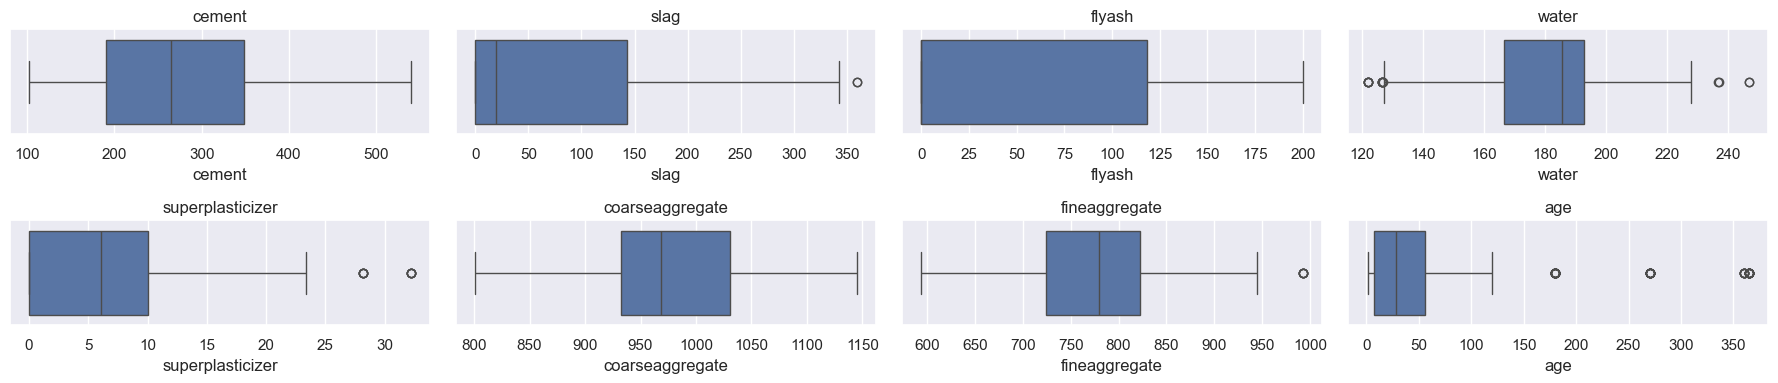

In [92]:
fig, axs = plt.subplots(2, 4, figsize = (18, 4))
grid = GridSpec(2, 4) #Concatena os gráficos, neste caso precisarei de 2 linhas e 4 colunas

#cement
sns.boxplot(x = 'cement', data = df4, ax = axs[0, 0])
axs[0, 0].set_title('cement')

#slag
sns.boxplot(x = 'slag', data = df4, ax = axs[0, 1])
axs[0, 1].set_title('slag')

#flyash
sns.boxplot(x = 'flyash', data = df4, ax = axs[0, 2])
axs[0, 2].set_title('flyash')

#water
sns.boxplot(x = 'water', data = df4, ax = axs[0, 3])
axs[0, 3].set_title('water')

#superplasticizer
sns.boxplot(x = 'superplasticizer', data = df4, ax = axs[1, 0])
axs[1, 0].set_title('superplasticizer')

#coarseaggregate
sns.boxplot(x = 'coarseaggregate', data = df4, ax = axs[1, 1])
axs[1, 1].set_title('coarseaggregate')

#fineaggregate
sns.boxplot(x = 'fineaggregate', data = df4, ax = axs[1, 2])
axs[1, 2].set_title('fineaggregate')

#age
sns.boxplot(x = 'age', data = df4, ax = axs[1, 3])
axs[1, 3].set_title('age')

# Ajustar o layout para não sobrepor os títulos
plt.tight_layout()
plt.show();

* A variável que possui mais outliers é a 'age', contudo as variáveis 'superplasticizer' e 'water' também mostram que possuem valores atípicos
Outliers são pontos de dados que se afastam significativamente do padrão geral de distribuição de uma variável. Eles podem ser causados por erros de medição, falhas nos processos de coleta de dados ou representar eventos raros e extremos. A presença de outliers pode distorcer a análises estatísticas e modelos, afetando negativamente sua precisão e interpretação.
No entanto, em alguns casos, outliers podem conter informações valiosas sobre o sistema ou fenômeno em estudo.

### 4.2 Análise bivariada

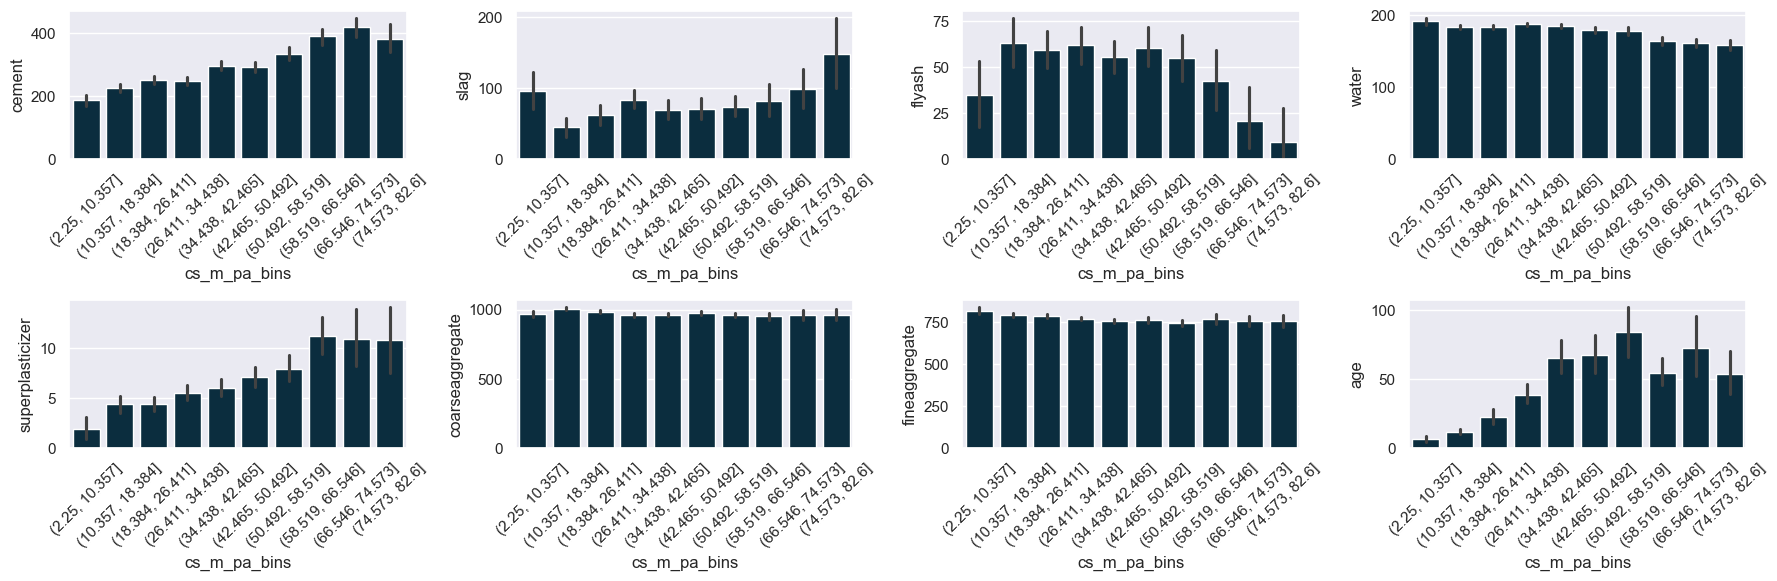

In [93]:
grid = GridSpec(2, 4, figure = plt.figure(figsize = (18, 6))) # Concatena os gráficos, neste caso precisarei de 2 linhas e 4 colunas

# Definindo a paleta de cores
color_palette = ['#023047', '#e85d04', '#0077b6', '#ff8200', '#0096c7', '#ff9c33']
sns.set_palette(sns.color_palette(color_palette))

aux = df4.copy()

# Dividindo os dados em 5 bins
aux['cs_m_pa_bins'] = pd.cut(df4['cs_m_pa'], bins = 10)

# Cement
ax1 = plt.subplot(grid[0, 0])
sns.barplot(x = 'cs_m_pa_bins', y = 'cement', data = aux, ax = ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 45)

# Slag
ax2 = plt.subplot(grid[0, 1])
sns.barplot(x = 'cs_m_pa_bins', y = 'slag', data = aux, ax = ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 45)

# Flyash
ax3 = plt.subplot(grid[0, 2])
sns.barplot(x = 'cs_m_pa_bins', y = 'flyash', data = aux, ax = ax3)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation = 45)

# Water
ax4 = plt.subplot(grid[0, 3])
sns.barplot(x = 'cs_m_pa_bins', y = 'water', data = aux, ax = ax4)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation = 45)

# Superplasticizer
ax5 = plt.subplot(grid[1, 0])
sns.barplot(x = 'cs_m_pa_bins', y = 'superplasticizer', data = aux, ax = ax5)
ax5.set_xticklabels(ax5.get_xticklabels(), rotation = 45)

# Coarseaggregate
ax6 = plt.subplot(grid[1, 1])
sns.barplot(x = 'cs_m_pa_bins', y = 'coarseaggregate', data = aux, ax = ax6)
ax6.set_xticklabels(ax6.get_xticklabels(), rotation = 45)

# Fineaggregate
ax7 = plt.subplot(grid[1, 2])
sns.barplot(x = 'cs_m_pa_bins', y = 'fineaggregate', data = aux, ax = ax7)
ax7.set_xticklabels(ax7.get_xticklabels(), rotation = 45)

# Age
ax8 = plt.subplot(grid[1, 3])
sns.barplot(x = 'cs_m_pa_bins', y = 'age', data = aux, ax = ax8)
ax8.set_xticklabels(ax8.get_xticklabels(), rotation = 45)

plt.tight_layout()
plt.show();


* O gráfico de barras que compara a variável resposta com as demais variáveis independentes ajuda a visualizar como a variável alvo varia em relação às diferentes categorias das variáveis independentes. Essa análise é útil para identificar padrões, tendências e relações entre as variáveis. No entanto, observa-se que as variáveis 'water', 'coarseaggregate' e 'fineaggregate' possuem pouca variabilidade em relação à variável resposta. Isso sugere que essas variáveis podem não contribuir de maneira significativa para o aprendizado do modelo, pois sua influência na variável resposta é limitada.

### 4.3 Análise multivariada

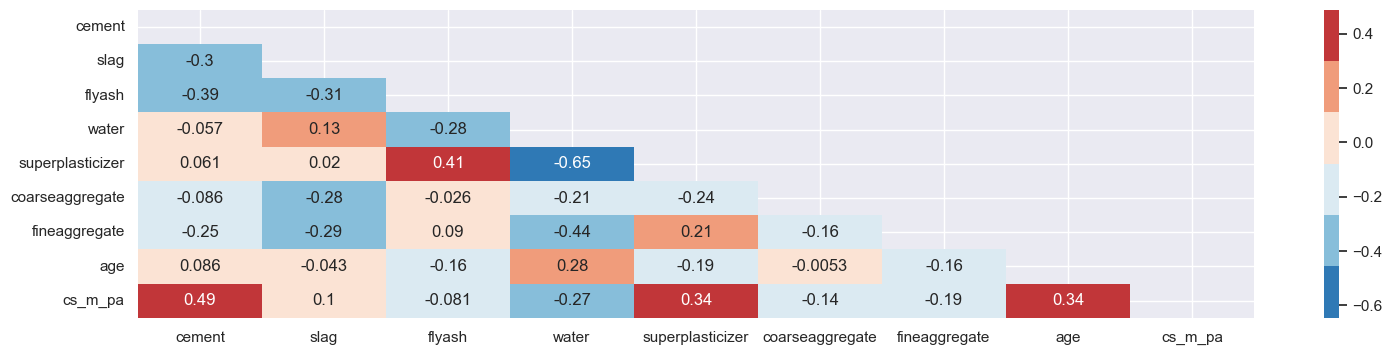

In [94]:
plt.figure(figsize = (18, 4))
correlation = df4.corr(method = 'pearson')
mask = np.triu(np.ones_like(correlation))
cmap = sns.color_palette('RdBu_r')
sns.heatmap(correlation, xticklabels = correlation.columns, yticklabels = correlation.columns, cmap = cmap, mask = mask, annot = True);

* Um gráfico de heatmap de correlações é como uma tabela de cores que mostra como as diferentes variáveis em seus dados estão relacionadas entre si. Cada quadrado na tabela representa a relação entre duas variáveis. A cor desse quadrado indica o quanto essas variáveis estão relacionadas: cores mais claras significam uma relação mais forte, enquanto cores mais escuras indicam uma relação mais fraca. Esses gráficos são úteis para entender as conexões entre diferentes partes dos seus dados de uma só vez, facilitando a identificação de padrões e relações importantes.
* É importante notar que busca-se uma forte relação entre as variáveis independentes e a variável dependente. Por outro lado, é desejável que haja uma baixa relação entre as variáveis independentes, a fim de evitar a multicolinearidade.

# 5. (Modelagem dos dados) Passo 5: Preparação dos dados

In [95]:
df5 = df4.copy()

### 5.1 Separar os dados em treino e teste

In [96]:
colunas_numericas = ['cement', 'slag', 'flyash', 'water', 'superplasticizer', 'coarseaggregate', 'fineaggregate', 'age']

colunas_categoricas = []

variavel_dependente = 'cs_m_pa'

variaveis_independentes = [col for col in colunas_numericas if col != variavel_dependente]

In [97]:
x = df5[variaveis_independentes]
y = df5[variavel_dependente].copy()

x_treino, x_teste, y_treino, y_teste = ms.train_test_split(x, y, test_size = 0.2, random_state = 42)

### 5.2 Pipeline dos dados

In [98]:
transformacao_numerica = Pipeline(steps = [('scaler', MinMaxScaler())]) # Aqui somente está sendo definido o que precisa ser feito
                                            # Nome da etapa
                                            # O objeto de transformação que será aplicado aos dados
                                            
#transformacao_categorica = OneHotEncoder(drop = 'if_binary', handle_unknown = 'ignore', sparse_output = False) 

preprocessor = ColumnTransformer(transformers = [('num', transformacao_numerica, colunas_numericas)])
                                                 # Um nome identificando a transformação
                                                 # Um objeto transformador ou um Pipeline
                                                 # As colunas às quais a transformação será aplicada

pd.DataFrame(preprocessor.fit_transform(x_treino)).head()

,0,1,2,3,4,5,6,7
0,0.98,0.00,0.00,0.16,0.88,0.15,0.75,0.01
1,0.85,0.00,0.00,0.85,0.00,0.39,0.00,0.02
2,0.40,0.00,0.49,0.31,0.37,0.52,0.71,0.01
3,0.76,0.00,0.00,0.77,0.00,0.11,0.32,0.07
4,0.15,0.70,0.00,0.65,0.00,0.52,0.25,0.02


In [99]:
pipeline_modelo = Pipeline(steps = [('preprocessor', preprocessor), 
                                    ('modelo', DummyRegressor())])

In [100]:
pipeline_modelo

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['cement', 'slag', 'flyash',
                                                   'water', 'superplasticizer',
                                                   'coarseaggregate',
                                                   'fineaggregate', 'age'])])),
                ('modelo', DummyRegressor())])

In [101]:
pipeline_modelo.named_steps

{'preprocessor': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('scaler', MinMaxScaler())]),
                                  ['cement', 'slag', 'flyash', 'water',
                                   'superplasticizer', 'coarseaggregate',
                                   'fineaggregate', 'age'])]),
 'modelo': DummyRegressor()}

In [102]:
pipeline_modelo['modelo']

DummyRegressor()

### 5.3 Treinar com vários modelos

In [103]:
modelos = [DummyRegressor(),
           LinearRegression(),
           LassoCV(),
           RidgeCV(),
           RandomForestRegressor(random_state = 42),
           GradientBoostingRegressor(random_state = 42)]

pipeline_modelo = Pipeline([('modelo', RandomForestRegressor(random_state = 42))])

# Configurando a busca bayesiana (BayesSearchCV)
bayesian_modelo = BayesSearchCV(pipeline_modelo,
                                search_spaces = {'modelo': modelos},
                                n_iter = 50,  # Número de iterações
                                cv = 5,  # Validação cruzada
                                n_jobs = -1,  # Usar todos os núcleos
                                scoring = 'neg_root_mean_squared_error',  # Métrica de avaliação
                                random_state = 42)

bayesian_modelo.fit(x_treino, y_treino)

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('modelo',
                                         RandomForestRegressor(random_state=42))]),
              n_jobs=-1, random_state=42, scoring='neg_root_mean_squared_error',
              search_spaces={'modelo': [DummyRegressor(), LinearRegression(),
                                        LassoCV(), RidgeCV(),
                                        RandomForestRegressor(random_state=42),
                                        GradientBoostingRegressor(random_state=42)]})

### 5.4 Modelo escolhido

In [104]:
bayesian_modelo.best_estimator_

Pipeline(steps=[('modelo', GradientBoostingRegressor(random_state=42))])

In [105]:
df_resultado = pd.DataFrame(bayesian_modelo.cv_results_).set_index('rank_test_score').sort_index()
df_resultado.loc[:, ~df_resultado.columns.str.contains('split|time')].head()

,param_modelo,params,mean_test_score,std_test_score
rank_test_score,,,,
1,GradientBoostingRegressor(random_state=42),{'modelo': GradientBoostingRegressor(random_st...,-5.35,0.43
1,GradientBoostingRegressor(random_state=42),{'modelo': GradientBoostingRegressor(random_st...,-5.35,0.43
1,GradientBoostingRegressor(random_state=42),{'modelo': GradientBoostingRegressor(random_st...,-5.35,0.43
1,GradientBoostingRegressor(random_state=42),{'modelo': GradientBoostingRegressor(random_st...,-5.35,0.43
1,GradientBoostingRegressor(random_state=42),{'modelo': GradientBoostingRegressor(random_st...,-5.35,0.43


### 5.5 Otimizar o modelo escolhido com os hiperparâmetros

In [106]:
pipeline_modelo = Pipeline(steps = [('preprocessor', preprocessor),
                                    ('modelo', GradientBoostingRegressor(random_state = 42))])

params = {'modelo__n_estimators': [200, 300],
          'modelo__learning_rate': [0.01, 0.9],
          'modelo__max_depth': [4, 10],
          'modelo__min_samples_split': [2, 12]}

bayesian_modelo = BayesSearchCV(pipeline_modelo,
                                search_spaces = params,
                                n_iter = 50, # Número de iterações
                                cv = 5, # Validação cruzada
                                n_jobs = -1, # Usar todos os núcleos
                                scoring = 'neg_root_mean_squared_error', # Métrica de avaliação
                                random_state = 42)

bayesian_modelo.fit(x_treino, y_treino)

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('num',
                                                                          Pipeline(steps=[('scaler',
                                                                                           MinMaxScaler())]),
                                                                          ['cement',
                                                                           'slag',
                                                                           'flyash',
                                                                           'water',
                                                                           'superplasticizer',
                                                                           'coarseaggregate',
                                                                           'fineaggregate',
                                                                           'age'])])),
                                        ('modelo',
                                         GradientBoostingRegressor(random_state=42))]),
              n_jobs=-1, random_state=42, scoring='neg_root_mean_squared_error',
              search_spaces={'modelo__learning_rate': [0.01, 0.9],
                             'modelo__max_depth': [4, 10],
                             'modelo__min_samples_split': [2, 12],
                             'modelo__n_estimators': [200, 300]})

In [107]:
df_resultado = pd.DataFrame(bayesian_modelo.cv_results_).set_index('rank_test_score').sort_index()
df_resultado.loc[:, ~df_resultado.columns.str.contains('split|time')].head()

,param_modelo__learning_rate,param_modelo__max_depth,param_modelo__n_estimators,params,mean_test_score,std_test_score
rank_test_score,,,,,,
1,0.18,4,300,"{'modelo__learning_rate': 0.1761120486334763, ...",-4.54,0.42
2,0.17,4,282,"{'modelo__learning_rate': 0.17019404095011625,...",-4.56,0.38
3,0.18,4,200,"{'modelo__learning_rate': 0.17526975358282376,...",-4.57,0.39
4,0.17,4,300,"{'modelo__learning_rate': 0.1744317525701407, ...",-4.59,0.42
5,0.16,4,285,"{'modelo__learning_rate': 0.1615054967395447, ...",-4.60,0.33


In [108]:
pipeline_modelo = bayesian_modelo.best_estimator_

In [109]:
y_pred = pipeline_modelo.predict(x_teste)

In [110]:
ml_error(y_teste, y_pred, desvpad = False)

,mae,mape,rmse,r2
0,2.69,9.05%,4.16,0.94


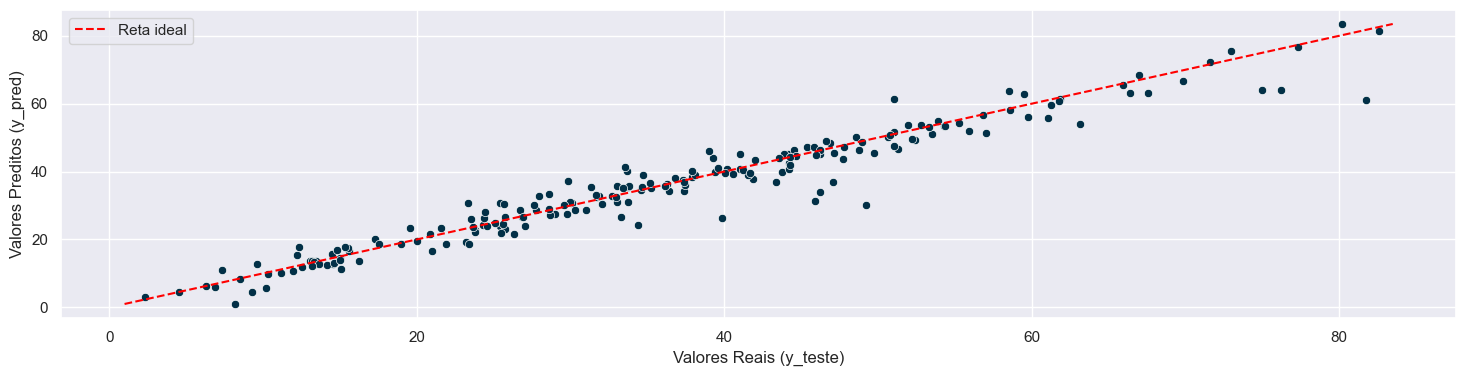

In [111]:
plt.figure(figsize = (18, 4)) # Largura = 18, Altura = 4
sns.scatterplot(x = y_teste, y = y_pred)

# Adiciona uma linha de referência (diagonal)
min_val = min(y_teste.min(), y_pred.min())  # Menor valor
max_val = max(y_teste.max(), y_pred.max())  # Maior valor
plt.plot([min_val, max_val], [min_val, max_val], color = 'red', linestyle = '--', label = 'Reta ideal')

plt.xlabel("Valores Reais (y_teste)")
plt.ylabel("Valores Preditos (y_pred)")
plt.legend()
plt.show();

# 6. (Modelagem dos dados) Passo 6: Seleção das variáveis

In [112]:
df6 = df5.copy()

### 6.1 Selecionar as variáveis mais relevantes do pipeline

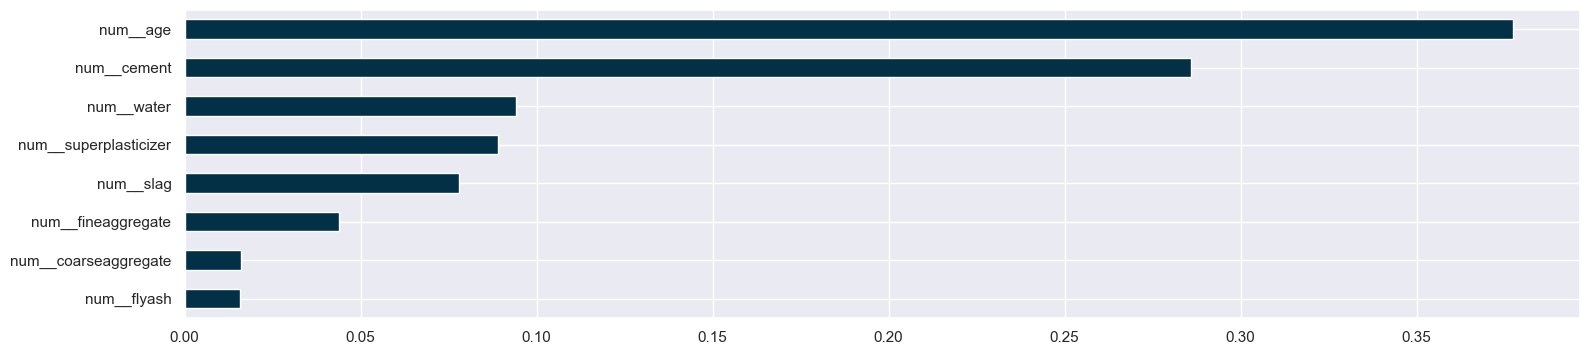

In [113]:
plt.figure(figsize = (18, 4)) # Largura = 18, Altura = 4

importances = pd.Series(data = pipeline_modelo.named_steps['modelo'].feature_importances_,
                        index = pipeline_modelo.named_steps['preprocessor'].get_feature_names_out())

importances.sort_values().plot.barh();

# 7. (Algoritmos de Ml) Passo 7: Treinar o modelo com as colunas mais relevantes

In [114]:
df7 = df6.copy()

In [115]:
colunas_selecionadas = ['age', 'cement', 'water', 'superplasticizer', 'slag', 'fineaggregate']

variavel_dependente = 'cs_m_pa'

variaveis_independentes = [col for col in colunas_selecionadas if col != variavel_dependente]

x = df7[variaveis_independentes]
y = df7[variavel_dependente].copy()

x_treino, x_teste, y_treino, y_teste = ms.train_test_split(x, y, test_size = 0.2, random_state = 42)

transformacao_numerica = Pipeline(steps = [('scaler', MinMaxScaler())]) # Aqui somente está sendo definido o que precisa ser feito
                                            # Nome da etapa
                                            # O objeto de transformação que será aplicado aos dados
                                            
preprocessor = ColumnTransformer(transformers = [('num', transformacao_numerica, colunas_selecionadas)])
                                                 # Um nome identificando a transformação
                                                 # Um objeto transformador ou um Pipeline
                                                 # As colunas às quais a transformação será aplicada

pipeline_modelo = Pipeline(steps = [('preprocessor', preprocessor),
                                    ('modelo', GradientBoostingRegressor(random_state = 42))])

params = {'modelo__n_estimators': [200, 300],
          'modelo__learning_rate': [0.01, 0.9],
          'modelo__max_depth': [4, 10],
          'modelo__min_samples_split': [2, 12]}

bayesian_modelo = BayesSearchCV(pipeline_modelo,
                                search_spaces = params,
                                n_iter = 50,  # Número de iterações
                                cv = 5,  # Validação cruzada
                                n_jobs = -1,  # Usar todos os núcleos
                                scoring = 'neg_root_mean_squared_error',  # Métrica de avaliação
                                random_state = 42)

bayesian_modelo.fit(x_treino, y_treino)

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('num',
                                                                          Pipeline(steps=[('scaler',
                                                                                           MinMaxScaler())]),
                                                                          ['age',
                                                                           'cement',
                                                                           'water',
                                                                           'superplasticizer',
                                                                           'slag',
                                                                           'fineaggregate'])])),
                                        ('modelo',
                                         GradientBoostingRegressor(random_state=42))]),
              n_jobs=-1, random_state=42, scoring='neg_root_mean_squared_error',
              search_spaces={'modelo__learning_rate': [0.01, 0.9],
                             'modelo__max_depth': [4, 10],
                             'modelo__min_samples_split': [2, 12],
                             'modelo__n_estimators': [200, 300]})

In [116]:
df_resultado = pd.DataFrame(bayesian_modelo.cv_results_).set_index('rank_test_score').sort_index()
df_resultado.loc[:, ~df_resultado.columns.str.contains('split|time')].head()

,param_modelo__learning_rate,param_modelo__max_depth,param_modelo__n_estimators,params,mean_test_score,std_test_score
rank_test_score,,,,,,
1,0.16,4,300,"{'modelo__learning_rate': 0.16369215394882689,...",-4.58,0.28
2,0.18,4,300,"{'modelo__learning_rate': 0.18417780200737013,...",-4.59,0.31
3,0.19,4,300,"{'modelo__learning_rate': 0.19455060319342127,...",-4.62,0.24
4,0.17,4,300,"{'modelo__learning_rate': 0.16825151160387675,...",-4.64,0.31
5,0.16,4,300,"{'modelo__learning_rate': 0.15865439262181727,...",-4.64,0.27


In [117]:
pipeline_modelo = bayesian_modelo.best_estimator_

y_pred = pipeline_modelo.predict(x_teste)

ml_error(y_teste, y_pred, desvpad = False)

,mae,mape,rmse,r2
0,2.58,9.19%,3.97,0.95


In [118]:
df1.tail(3)

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,cs_m_pa
1027,148.50,139.40,108.60,192.70,6.10,892.40,780.00,28,23.70
1028,159.10,186.70,0.00,175.60,11.30,989.60,788.90,28,32.77
1029,260.90,100.50,78.30,200.60,8.60,864.50,761.50,28,32.40


In [119]:
dados = pd.DataFrame({'cement': [148.5],
                      'slag': [139.40],
                      'flyash': [108.60],
                      'water': [192.70],
                      'superplasticizer': [6.10],
                      'coarseaggregate': [892.40],
                      'fineaggregate': [780.00],
                      'age': [28]})
y_pred = pipeline_modelo.predict(dados)
y_pred

array([23.54222176])

# 9. (Avaliação do algoritmo) Passo 9: Performance do negócio ROI

* **MAE:** (Erro Absoluto Médio) calcula a média da diferença absoluta entre os valores previstos (y_pred) e os valores reais (y).  
É interpretado como a média das magnitudes dos erros de previsão.  
    **Exemplo:** Em média, suas previsões estão a (x) unidades de distância do valor real. Ou seja, seus modelos estão subestimando ou superestimando o valor real em uma média de (x) unidades.
    
* **MAPE:** (Erro Absoluto Percentual Médio) calcula a média dos erros absolutos relativos (porcentagem).  
É interpretado como a média percentual dos erros de previsão em relação aos valores reais.  
    **Exemplo:** Em média, suas previsões estão erradas em (x %) em relação ao valor real. Isso significa que, em média, seus modelos estão prevendo valores que são (x %) maiores ou menores que o valor real.

* **RMSE:** (Raiz do Erro Quadrático Médio) calcula a raiz quadrada da média das diferenças quadráticas entre os valores reais (y) e previstos (y_pred).  
  É interpretado como a magnitude do erro padrão médio.  
  **Exemplo:** Em média, o erro das previsões está a (x) unidades do valor real, refletindo a magnitude dos erros de previsão.
    
* **R²:** (Coeficiente de Determinação) mede a proporção da variância nos valores reais (y) que é explicada pelos valores previstos (y_pred).  
  É interpretado como a proporção de variação total que é explicada pelo modelo.  
  **Exemplo:** Um R² de (x) significa que o modelo explica (x)% da variabilidade observada nos dados.

In [120]:
y_pred = pipeline_modelo.predict(df1)

In [121]:
dados_orig = df1.copy()
dados_orig['prediction'] = y_pred
dados_orig['prediction'] = dados_orig['prediction'].round(2)
pd.options.display.float_format = '{:.2f}'.format

In [122]:
dados_orig.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,cs_m_pa,prediction
0,540.00,0.00,0.00,162.00,2.50,1040.00,676.00,28,79.99,70.98
1,540.00,0.00,0.00,162.00,2.50,1055.00,676.00,28,61.89,70.98
2,332.50,142.50,0.00,228.00,0.00,932.00,594.00,270,40.27,40.45
3,332.50,142.50,0.00,228.00,0.00,932.00,594.00,365,41.05,41.29
4,198.60,132.40,0.00,192.00,0.00,978.40,825.50,360,44.30,44.03


In [123]:
dados_orig_cost = pd.DataFrame()

dados_orig_cost['cement_cost'] = dados_orig['cement'] * 12
dados_orig_cost['slag_cost'] = dados_orig['slag'] * 15
dados_orig_cost['flyash_cost'] = dados_orig['flyash'] * 8
dados_orig_cost['water_cost'] = dados_orig['water'] * 5
dados_orig_cost['superplasticizer_cost'] = dados_orig['superplasticizer'] * 18
dados_orig_cost['coarseaggregate_cost'] = dados_orig['coarseaggregate'] * 12
dados_orig_cost['fineaggregate_cost'] = dados_orig['fineaggregate'] * 13
dados_orig_cost['age_cost'] = dados_orig['age'] * 5
dados_orig_cost['total_cost'] = dados_orig_cost.sum(axis = 1)
dados_orig_cost['prediction'] = dados_orig['prediction']

In [124]:
df1.columns

Index(['cement', 'slag', 'flyash', 'water', 'superplasticizer',
       'coarseaggregate', 'fineaggregate', 'age', 'cs_m_pa'],
      dtype='object')

In [125]:
data = {'Variável': ['cement', 'slag', 'flyash', 'water', 'superplasticizer', 'coarseaggregate', 'fineaggregate', 'age'],
        'Custo_unitário': [12, 15, 8, 5, 18, 12, 13, 5]}

df = pd.DataFrame(data)
df

,Variável,Custo_unitário
0,cement,12
1,slag,15
2,flyash,8
3,water,5
4,superplasticizer,18
5,coarseaggregate,12
6,fineaggregate,13
7,age,5


* Para fins de simulação, foram estabelecidos valores de custo unitário para cada variável.

In [126]:
dados_orig_cost.head()

,cement_cost,slag_cost,flyash_cost,water_cost,superplasticizer_cost,coarseaggregate_cost,fineaggregate_cost,age_cost,total_cost,prediction
0,6480.00,0.00,0.00,810.00,45.00,12480.00,8788.00,140,28743.00,70.98
1,6480.00,0.00,0.00,810.00,45.00,12660.00,8788.00,140,28923.00,70.98
2,3990.00,2137.50,0.00,1140.00,0.00,11184.00,7722.00,1350,27523.50,40.45
3,3990.00,2137.50,0.00,1140.00,0.00,11184.00,7722.00,1825,27998.50,41.29
4,2383.20,1986.00,0.00,960.00,0.00,11740.80,10731.50,1800,29601.50,44.03


* A variável foi atualizada, multiplicando o valor de cada linha pelo custo unitário. Assim, a coluna 'total_cost' agora reflete o custo total de cada item.

In [127]:
# Calcular o maior
maior_valor = dados_orig_cost['prediction'].max()

# Criar os bins
bins = list(np.arange(0, maior_valor + 1, 10))

# Definir os rótulos das faixas
labels = [f'{i:.2f}-{i+9.99:.2f}' for i in range(0, int(maior_valor) - 9, 10)]

# Criar uma nova coluna com as faixas
dados_orig_cost['cs_m_pa_prediction'] = pd.cut(dados_orig_cost['prediction'], bins = bins, labels = labels)

dados_orig_cost[['cs_m_pa_prediction', 'total_cost']].groupby('cs_m_pa_prediction').sum().reset_index()

,cs_m_pa_prediction,total_cost
0,0.00-9.99,954320.40
1,10.00-19.99,4348555.80
2,20.00-29.99,5404553.20
3,30.00-39.99,7090778.70
4,40.00-49.99,4707966.90
5,50.00-59.99,3319984.50
6,60.00-69.99,1487034.80
7,70.00-79.99,620665.40


* Na coluna 'cs_m_pa_prediction', as faixas de resistência à compressão (cs_m_pa) foram agrupadas em intervalos de 9,99 de amplitude.

In [128]:
intervalos_60_69_aux = dados_orig_cost.loc[dados_orig_cost['cs_m_pa_prediction'] == '60.00-69.99', ['cs_m_pa_prediction', 'total_cost']].sort_values('total_cost', ascending = True)
intervalos_60_69 = pd.concat([intervalos_60_69_aux.iloc[0, :], intervalos_60_69_aux.iloc[-1, :]], axis = 1).T
intervalos_60_69['variacao_%'] = 1 - (intervalos_60_69['total_cost'].min() / intervalos_60_69['total_cost'].max())

intervalos_50_59_aux = dados_orig_cost.loc[dados_orig_cost['cs_m_pa_prediction'] == '50.00-59.99', ['cs_m_pa_prediction', 'total_cost']].sort_values('total_cost', ascending = True)
intervalos_50_59 = pd.concat([intervalos_50_59_aux.iloc[0, :], intervalos_50_59_aux.iloc[-1, :]], axis = 1).T
intervalos_50_59['variacao_%'] = 1 - (intervalos_50_59['total_cost'].min() / intervalos_50_59['total_cost'].max())

intervalos_40_49_aux = dados_orig_cost.loc[dados_orig_cost['cs_m_pa_prediction'] == '40.00-49.99', ['cs_m_pa_prediction', 'total_cost']].sort_values('total_cost', ascending = True)
intervalos_40_49 = pd.concat([intervalos_40_49_aux.iloc[0, :], intervalos_40_49_aux.iloc[-1, :]], axis = 1).T
intervalos_40_49['variacao_%'] = 1 - (intervalos_40_49['total_cost'].min() / intervalos_40_49['total_cost'].max())

intervalos_30_39_aux = dados_orig_cost.loc[dados_orig_cost['cs_m_pa_prediction'] == '30.00-39.99', ['cs_m_pa_prediction', 'total_cost']].sort_values('total_cost', ascending = True)
intervalos_30_39 = pd.concat([intervalos_30_39_aux.iloc[0, :], intervalos_30_39_aux.iloc[-1, :]], axis = 1).T
intervalos_30_39['variacao_%'] = 1 - (intervalos_30_39['total_cost'].min() / intervalos_30_39['total_cost'].max())

intervalos_20_29_aux = dados_orig_cost.loc[dados_orig_cost['cs_m_pa_prediction'] == '20.00-29.99', ['cs_m_pa_prediction', 'total_cost']].sort_values('total_cost', ascending = True)
intervalos_20_29 = pd.concat([intervalos_20_29_aux.iloc[0, :], intervalos_20_29_aux.iloc[-1, :]], axis = 1).T
intervalos_20_29['variacao_%'] = 1 - (intervalos_20_29['total_cost'].min() / intervalos_20_29['total_cost'].max())

intervalos_10_19_aux = dados_orig_cost.loc[dados_orig_cost['cs_m_pa_prediction'] == '10.00-19.99', ['cs_m_pa_prediction', 'total_cost']].sort_values('total_cost', ascending = True)
intervalos_10_19 = pd.concat([intervalos_10_19_aux.iloc[0, :], intervalos_10_19_aux.iloc[-1, :]], axis = 1).T
intervalos_10_19['variacao_%'] = 1 - (intervalos_10_19['total_cost'].min() / intervalos_10_19['total_cost'].max())

intervalos_0_9_aux = dados_orig_cost.loc[dados_orig_cost['cs_m_pa_prediction'] == '0.00-9.99', ['cs_m_pa_prediction', 'total_cost']].sort_values('total_cost', ascending = True)
intervalos_0_9 = pd.concat([intervalos_0_9_aux.iloc[0, :], intervalos_0_9_aux.iloc[-1, :]], axis = 1).T
intervalos_0_9['variacao_%'] = 1 - (intervalos_0_9['total_cost'].min() / intervalos_0_9['total_cost'].max())

In [129]:
resultado = pd.concat([intervalos_0_9, intervalos_10_19, intervalos_20_29, intervalos_30_39, intervalos_40_49, intervalos_50_59, intervalos_60_69], axis = 0)
resultado.reset_index(drop = True)

,cs_m_pa_prediction,total_cost,variacao_%
0,0.00-9.99,24936.60,0.14
1,0.00-9.99,28844.90,0.14
2,10.00-19.99,25646.00,0.12
3,10.00-19.99,29073.00,0.12
4,20.00-29.99,25440.00,0.15
5,20.00-29.99,29892.50,0.15
6,30.00-39.99,25530.40,0.15
7,30.00-39.99,30105.20,0.15
8,40.00-49.99,25886.00,0.15
9,40.00-49.99,30629.90,0.15


* Na tabela acima, são apresentadas as diferenças percentuais entre os valores de cs_m_pa correspondentes a cada intervalo. Por exemplo, para a faixa entre 10.00-19.99, os custos variam de 25646,00 a 29073,00, resultando em uma diferença de 12% entre o maior e o menor valor de custo. Este padrão é seguido para os demais intervalos.

In [130]:
#Salvando o modelo treinado em Pickle
pickle.dump(pipeline_modelo, open('/home/leonardo/projetos_/qualidade_concreto_DNC/Deploy_DNC/fastapi/modelo/modelo_treinado.pkl', 'wb'))

# 10. (Modelo em produção) Passo 10 Modelo em produção

### 10.1 Classe do projeto (salvar como script.py)

In [131]:
import pickle
import pandas                                  as pd
import numpy                                   as np

class Projeto:
    def __init__(self):
        self.home_path = '/home/leonardo/projetos_/qualidade_concreto/transformacoes'
        self.age_mms = pickle.load(open(self.home_path + 'age_mms.pkl', 'rb'))
        self.cement_mms = pickle.load(open(self.home_path + 'cement_mms.pkl', 'rb'))
        self.coarseaggregate_mms = pickle.load(open(self.home_path + 'coarseaggregate_mms.pkl', 'rb'))
        self.fineaggregate_mms = pickle.load(open(self.home_path + 'fineaggregate_mms.pkl', 'rb'))
        self.flyash_mms = pickle.load(open(self.home_path + 'flyash_mms.pkl', 'rb'))
        self.slag_mms = pickle.load(open(self.home_path + 'slag_mms.pkl', 'rb'))
        self.superplasticizer_mms = pickle.load(open(self.home_path + 'superplasticizer_mms.pkl', 'rb'))
        self.water_mms = pickle.load(open(self.home_path + 'water_mms.pkl', 'rb'))

    def transformacao_dos_dados(self, df5):
        df5['age'] = self.age_mms.transform(df5[['age']].values)
        df5['cement'] = self.cement_mms.transform(df5[['cement']].values)
        df5['coarseaggregate'] = self.coarseaggregate_mms.transform(df5[['coarseaggregate']].values)
        df5['fineaggregate'] = self.fineaggregate_mms.transform(df5[['fineaggregate']].values)
        df5['flyash'] = self.flyash_mms.transform(df5[['flyash']].values)
        df5['slag'] = self.slag_mms.transform(df5[['slag']].values)
        df5['superplasticizer'] = self.superplasticizer_mms.transform(df5[['superplasticizer']].values)
        df5['water'] = self.water_mms.transform(df5[['water']].values)

        #Colunas selecionadas a partir a importância das variáveis
        colunas_selecionadas = ['cement', 'age']
        return df5[colunas_selecionadas]

    def get_prediction(self, modelo, dados_original, dados_teste):
        pred = modelo.predict(dados_teste)
        dados_original['Score'] = np.expm1(pred)
        return dados_original.to_json(orient = 'records', date_format = 'iso')

### 10.2 Criar API (salvar como handler.py)

In [132]:
import pickle
import pandas as pd
from flask import Flask, request, Response

#Diretório onde está salvo a API handler.py
#Nome do arquivo.py
#Nome da classe que foi criada dentro do arquivo.py

#from Diretório.arquivo        import classe
from script import Projeto

# Carregando o modelo treinado usando pickle
modelo = pickle.load(open('/home/leonardo/projetos_/qualidade_concreto/modelo/modelo_treinado.pkl', 'rb'))

app = Flask(__name__)

@app.route('/predict', methods = ['POST'])
def predict():
    teste_json = request.get_json() #Recebe um arquivo JSON a partir da request

    if teste_json:  #Se o teste_json for diferente de vazio, ou seja, se foi carregado algum dado
        #Verifica se o arquivo passado é um tipo de dicionário e se sim, foi enviado um arquivo com somente uma linha
        if isinstance(teste_json, dict):
            #Cria um dataframe e para isso é necessário indicar no Pandas qual é o nº da linha inicial, nesta caso, 0
            dados_originais = pd.DataFrame(teste_json, index = [0])
        else:
            #Se não for é um dicionário, foi enviado um arquivo com mais de uma linha
            dados_originais = pd.DataFrame(teste_json, columns = teste_json[0].keys())

        #Instanciando a classe do projeto
        pipeline = Projeto()

        #Transformação dos dados
        df5 = pipeline.transformacao_dos_dados(dados_originais)
        
        #predição
        df_resposta = pipeline.get_prediction(modelo, dados_originais, df5)
        
        return df_resposta
    else:
        return Response('{}', status = 200, mimetype = 'application/json')

if __name__ == '__main__':
    #Dizer para endpoint rodar no localhost (rodando na máquina)
    #port = os.environ.get('PORT', 5000)
    #app.run('0.0.0.0', port = port)
    app.run('0.0.0.0', debug = True)

ModuleNotFoundError: No module named 'flask'

### 10.3 Testar a API

In [ ]:
import requests

#Carregando os dados para teste
df_teste = df1.copy()

In [ ]:
df_teste = df_teste.drop('cs_m_pa', axis = 1).head()
df_teste

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age
995,158.60,148.90,116.00,175.10,15.00,953.30,719.70,28
507,424.00,22.00,132.00,178.00,8.50,822.00,750.00,28
334,275.10,0.00,121.40,159.50,9.90,1053.60,777.50,3
848,252.00,97.00,76.00,194.00,8.00,835.00,821.00,28
294,168.90,42.20,124.30,158.30,10.80,1080.80,796.20,3


In [ ]:
import json

#Convertendo o dataframe em formato JSON
data_json = json.dumps(df_teste.to_dict(orient = 'records')) 
data_json

'[{"cement": 158.6, "slag": 148.9, "flyash": 116.0, "water": 175.1, "superplasticizer": 15.0, "coarseaggregate": 953.3, "fineaggregate": 719.7, "age": 28}, {"cement": 424.0, "slag": 22.0, "flyash": 132.0, "water": 178.0, "superplasticizer": 8.5, "coarseaggregate": 822.0, "fineaggregate": 750.0, "age": 28}, {"cement": 275.1, "slag": 0.0, "flyash": 121.4, "water": 159.5, "superplasticizer": 9.9, "coarseaggregate": 1053.6, "fineaggregate": 777.5, "age": 3}, {"cement": 252.0, "slag": 97.0, "flyash": 76.0, "water": 194.0, "superplasticizer": 8.0, "coarseaggregate": 835.0, "fineaggregate": 821.0, "age": 28}, {"cement": 168.9, "slag": 42.2, "flyash": 124.3, "water": 158.3, "superplasticizer": 10.8, "coarseaggregate": 1080.8, "fineaggregate": 796.2, "age": 3}]'

### Para colocar a API "de pé", digitar no terminal no nome da API, neste caso, python api_handler.py

In [ ]:
#Chamando a API
import json

data_json = json.dumps(df_teste.to_dict(orient = 'records')) #Convertendo o dataframe em formato JSON
#url = 'https://health-insurance-ixwn.onrender.com/predict' #Este é o formato de endereço a de um servidor na nuvem
#url = 'https://qualidade-concreto.onrender.com/predict'
url = 'http://0.0.0.0:5000/predict' #Endpoint -> 0.0.0.0 é a máquina local e :5000 é a porta padrão da biblioteca flask
header = {'Content-type': 'application/json'} #Indica para o API qual tipo de dado ele está recebendo
r = requests.post(url, data = data_json, headers = header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [ ]:
pd.DataFrame(r.json(), columns = r.json()[0].keys())

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,Score
0,158.60,148.90,116.00,175.10,15.00,953.30,719.70,28,27.41
1,424.00,22.00,132.00,178.00,8.50,822.00,750.00,28,61.50
2,275.10,0.00,121.40,159.50,9.90,1053.60,777.50,3,23.19
3,252.00,97.00,76.00,194.00,8.00,835.00,821.00,28,33.44
4,168.90,42.20,124.30,158.30,10.80,1080.80,796.20,3,7.74
